# Programming language:

**Julia 1.6.5**

In [3]:
using Plots; pyplot()
using Plots.Measures
using DelimitedFiles, DataFrames, CSV, JLD
using StatsBase    
using Combinatorics
using ProgressMeter
using LaTeXStrings

In [4]:
dir_source_data = "/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/Manuscript_SourceData/SourceData"



"/n/holyscratch01/mallet_lab/txiong/Research/2022_HybridSterility/Manuscript_SourceData/SourceData"

## 1. Consanguinity analysis

In [6]:
# unzip 04.0_IBD.NgsRelate.zip inside folder "FigS3" before running the following code

dir_source = "$(dir_source_data)/FigS3/04.0_IBD.NgsRelate"

cd(dir_source)

In [7]:
chr_list = 1:29
θ_all = zeros(68265,0)

sp1 = zeros(370)
sp2 = zeros(370)


k = 0

for chr in chr_list
    
    if isfile("Joint.HiC_scaffold_$(chr).snp.filtered2.vcf.gz.res.spill0.res")
        continue
    else

        df = DataFrame(CSV.File("Joint.HiC_scaffold_$(chr).snp.filtered2.vcf.gz.res"))

        if k == 0
            # convert output of ngsrelate's individual indices to my own sample indices
            sp1 = 370 .- df[!,:a]
            sp2 = 370 .- df[!,:b]
        end
        
        k = k+1

        θ = df[!,:theta]
        θ_all = hcat(θ_all,θ)
    end
end

println(k)

θ_average = dropdims(mean(θ_all;dims=2),dims=2);

29


In [9]:
function get_θ(sp_list_1,sp_list_2,θ_data,sampleID1,sampleID2)
    
    sampleID1 = parse(Int64,sampleID1)
    sampleID2 = parse(Int64,sampleID2)
    
    sampleID_min = min(sampleID1,sampleID2)
    sampleID_max = max(sampleID1,sampleID2)
    
    idx = findfirst((sampleID_max .== sp_list_1) .* (sampleID_min .== sp_list_2))
    return θ_data[idx]
end

function compare_family_to_family(f1,f2,FamilyID,sampleID)
    
    Samples1 = sampleID[FamilyID .== f1]
    Samples2 = sampleID[FamilyID .== f2]
    
    if f1 == f2
        
        N = size(Samples1)[1]
        
        K = zeros(N,N) .- 1
               
        for (i,j) in collect(combinations(1:N, 2))
            
            K[i,j] = get_θ(sp1,sp2,θ_average,Samples1[i],Samples1[j])
            
        end
        
    elseif f1 != f2
        
        N1 = size(Samples1)[1]
        N2 = size(Samples2)[1]
        
        K = zeros(N1,N2) .- 1
        
        for i in 1:N1
            for j in 1:N2
                if Samples1[i] == Samples2[j]
                    continue
                else
                    K[i,j] = get_θ(sp1,sp2,θ_average,Samples1[i],Samples2[j])
                end
            end
        end
        
    end
    
    return K,Samples1,Samples2
    
end

compare_family_to_family (generic function with 1 method)

#### Plot every individual together

In [18]:
df = DataFrame(CSV.File("$(dir_source_data)/FigS3/Individuals_ordered_by_family_plusPandGP_afterCorrection.csv"))

FamilyID = df[1:end,1]
IndividualID = df[1:end,2]
t = split.(IndividualID,"S")
sampleID = [i[2] for i in t];

In [19]:
family_border_idx = zeros(2,0)

for f in unique(FamilyID)
    idx = findall(FamilyID .== f)

    family_border_idx = hcat(family_border_idx,[minimum(idx),maximum(idx)])
end

family_border_idx = Int64.(family_border_idx);

In [20]:
K = zeros(370,370) .- 1

for (i,j) in combinations(1:370,2)
    
    K[i,j] = get_θ(sp1,sp2,θ_average,sampleID[i],sampleID[j])
    
end

K[K .== -1] .= NaN;

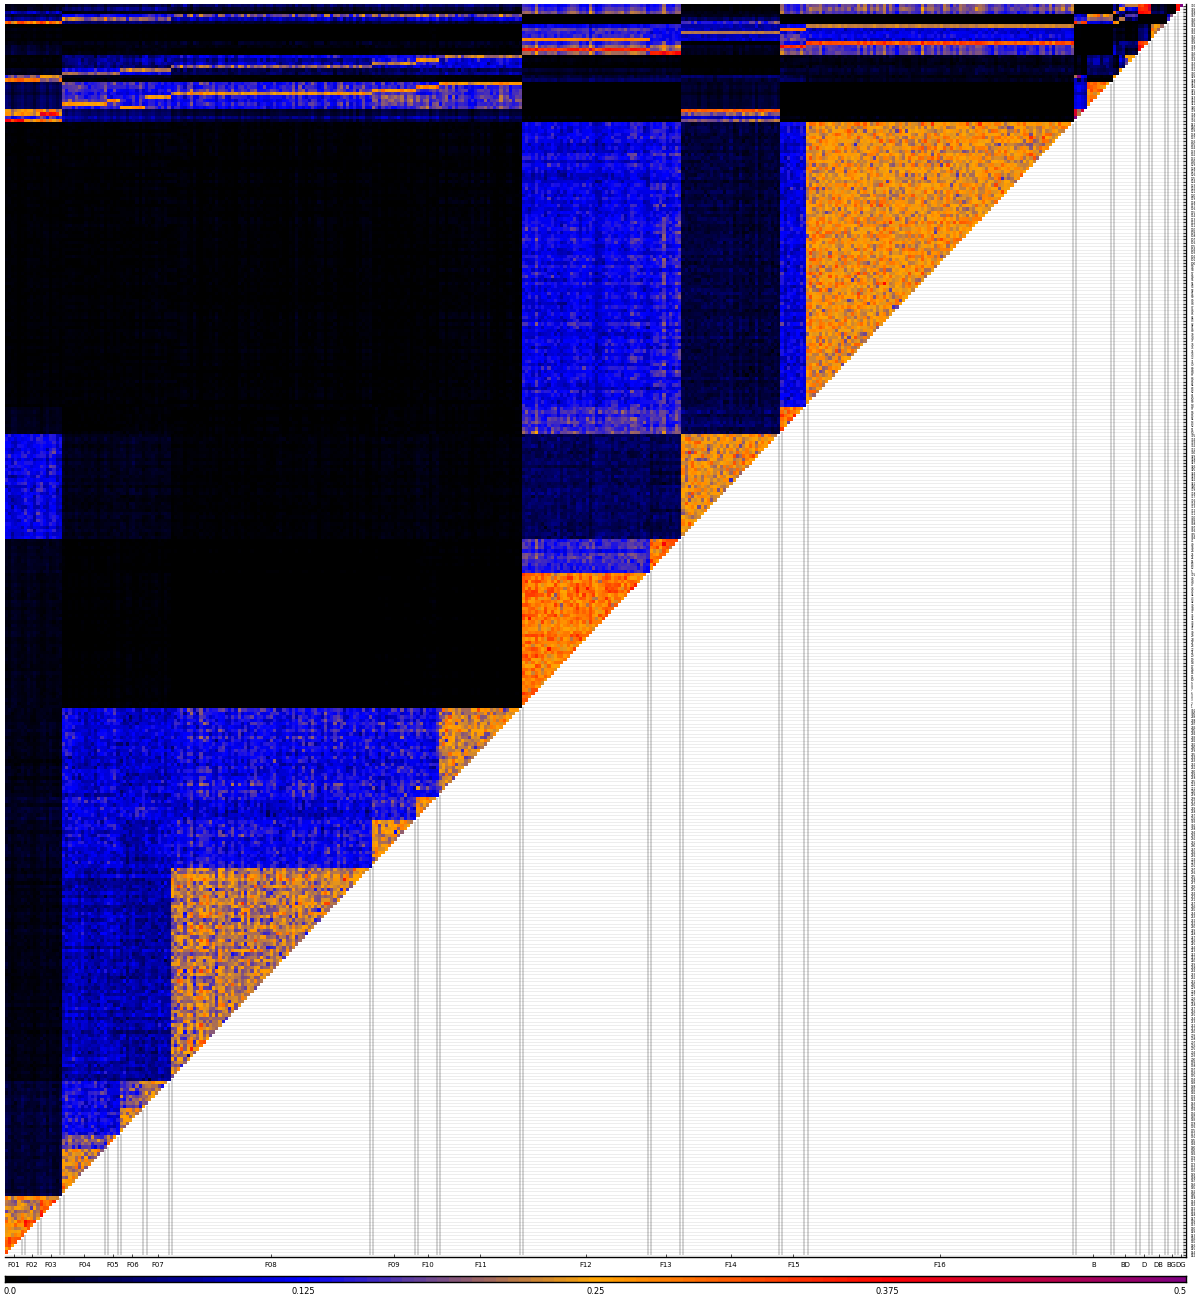

In [21]:
l = @layout [a; b{0.005h}]
fig = plot(size=(1200,1300),layout=l)
color_scheme = cgrad([:black,:blue,:orange,:red,:purple], rev=false)
heatmap!(fig,transpose(K),
    # xticks=(Array(1:size(sampleID)[1]) .+ 0,sampleID),
    yticks=(Array(1:size(sampleID)[1]) .+ 0,sampleID),
    xlabel="",ylabel="",
    ymirror=true,
    color=color_scheme,
    ygrid=:on,
    xgrid=:off,
    xguidefontsize=8,
    # right_margin=0mm,
    yguidefontsize=8,
    xtickfontsize=5,
    ytickfontsize=2,
    xrotation=90,
    # aspect_ratio=1,
    colorbar=false,
    xlims=(0.5,size(sampleID)[1]+0.5),
    ylims=(0.5,size(sampleID)[1]+0.5),
    clims=(-0.0,1/2),
    subplot=1)



heatmap!(fig,reshape(0:0.01:1,1,101),
    xticks=([0,25,50,75,100] .+ 1,[0,0.25,0.5,0.75,1]./2),
    yticks=[],
    xtickfontsize=6,
    label="",
    grid=:off,
    framestyle=:box,
    clims=(-0.0,1.0),
    color=color_scheme,
    colorbar=false,
    subplot=2)

for i in 1:size(family_border_idx)[2]
    
    plot!(fig,[family_border_idx[1,i],family_border_idx[1,i]],[1,family_border_idx[1,i]],
        label="",
        linewidth=0.25,
        color=:black,
        subplot=1)
    plot!(fig,[family_border_idx[2,i],family_border_idx[2,i]],[1,family_border_idx[2,i]],
        label="",
        linewidth=0.25,
        color=:black,
        subplot=1)
    
end

xticks!(fig,
    ((family_border_idx[1,:] .+ family_border_idx[2,:])./2,unique(FamilyID)),
    subplot=1)

fig

In [22]:
dir_output = "$(dir_source_data)/FigS3"

fig_name = "Kinship_afterCorrection"

savefig(fig,string(dir_output,"/$(fig_name).pdf"))
savefig(fig,string(dir_output,"/$(fig_name).png"))

## 2. Analysis of inferred ancestry haplotypes


### 2.1. OrderMarker2 Output

In [33]:
function get_marker_pos(chr::Int64,dir)
    
    pos = readdlm("$(dir_source_data)/FigS5toS7/data.call.with_pseudoGrandparents.fixedDiff_only.marker_positions/chr.$(chr).txt",String)
    
    return [parse(Int32,i[1]) for i in split.(pos,"*")][:,1]::Array{Int32,1}
    
end

get_marker_pos (generic function with 1 method)

In [34]:
function get_individual_alleles(x)
    
    Y = Bool[]
    for y in x
        z = split(y," ")[1]::SubString{String}
        z = parse.(Bool,split(z[1:Int(length(z)/2)],""))::BitVector
        Y = vcat(Y,z)
    end
    
    return Y::Vector{Bool}
    
end

get_individual_alleles (generic function with 1 method)

In [35]:
function get_recombination_breakpoints(h)
    
    δh = h[:,2:end] .- h[:,1:end-1]
    
    transitions = δh .!= 0
    
    return [findall(transitions[i,:]) for i in 1:size(transitions)[1]]
    
end

get_recombination_breakpoints (generic function with 1 method)

### 2.2 Inferring crossover patterns

In [36]:
f_0co_all = []
f_1co_all = []
f_2co_all = []

n_0re_all = []
n_1re_all = []
n_2re_all = []

for chr1 in 1:30

println(chr1)
    
family = "F01-F16"

if family == "F12-F16"
    f_idx = Array(12:16)
elseif family == "F01-F11"
    f_idx = Array(1:11)
else
    f_idx = Array(1:16)
end

marker_skips=2

interference = "0.001"
subdir = "impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"

marker_idx_1 = []
male_cM_1 = []
hap1 = []

open("$(dir_source_data)/FigS5toS7/$(subdir)/impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference).$(family).chr.$(chr1).txt","r") do io
    i=1
    for l in eachline(io)
        if string(l[1]) != "#"
            x = split(l,"\t")
            push!(marker_idx_1,x[1])
            push!(male_cM_1,x[2])
            push!(hap1,get_individual_alleles(x[f_idx .+ 4]))
            i = i+1
        end
    end
end

marker_idx_1 = parse.(Int32,marker_idx_1)
male_cM_1 = parse.(Float32,male_cM_1)
hap1 = hcat(hap1...)
    
hap1 = Float16.(hap1)

GC.gc()

idx = 1:marker_skips:size(hap1)[2]
h1 = hap1[:,idx]
m_cM_1 = male_cM_1[idx]

N=size(h1)[1]

marker_pos_1 = get_marker_pos(chr1,dir_source)

x_pos = marker_pos_1[marker_idx_1[idx]]

breakpoints = get_recombination_breakpoints(h1)
n_recombinations = length.(breakpoints)

if any(n_recombinations .> 2)
    n_toomany = sum(n_recombinations .> 2)
    println("Chr$(chr1): More than 2 recombinations detected in $(n_toomany) samples!!")
end

n0 = sum(n_recombinations .== 0)
n1 = sum(n_recombinations .== 1)
n2 = sum(n_recombinations .== 2)

push!(n_0re_all,n0)
push!(n_1re_all,n1)
push!(n_2re_all,n2)

  
f_0co = (n0-n1+n2)/(n0+n1+n2)
f_1co = 2*(n1-2*n2)/(n0+n1+n2)
f_2co = 4*n2/(n0+n1+n2)
    
if any([f_0co,f_1co,f_2co].<0) & (n2 > 0)
    f_0co = 0
    f_1co = 1-2*n2/(n0+n2)
    f_2co = 2*n2/(n0+n2)
elseif any([f_0co,f_1co,f_2co].<0) & (n2==0)
    f_0co = max(0,(n0-n1)/(n0+n1))
    f_1co = min(1,2*n1/(n0+n1))
    f_2co = 0
end

if chr1==14
    push!(f_0co_all,NaN)
    push!(f_1co_all,NaN)
    push!(f_2co_all,NaN)
else 
    push!(f_0co_all,f_0co)
    push!(f_1co_all,f_1co)
    push!(f_2co_all,f_2co)
end

end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
Chr14: More than 2 recombinations detected in 1 samples!!
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


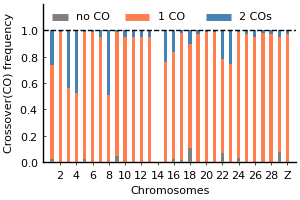

In [37]:
fig = plot(size=(300,200))

x = 1:30

dx = 0.4
bar!(fig,x,f_0co_all .+ f_1co_all .+ f_2co_all,
    xticks=(Array(2:2:30),vcat(string.(Array(2:2:28)),["Z"])),
    xlims=(-Inf,+Inf),
    grid=:off,
    bar_position = :stack,
    color=:steelblue,
    bar_width=0.4,
    linewidth=0,
    label="",
    xlabel="Chromosomes",
    ylabel="Crossover(CO) frequency",
    xguidefontsize=8,
    yguidefontsize=8,
    legend_background_color=false,
    legend=:topleft,
    # legend_column=3,
    xtick_direction=:out,
    yticks=0:0.2:1,
    ylims=(0,1.2),
)

bar!(fig,x,f_0co_all .+ f_1co_all,
    bar_width=0.4,
    linewidth=0,
    color=:coral,
    label="",
    )

bar!(fig,x,f_0co_all,
    bar_width=0.4,
    linewidth=0,
    color=:gray,
    label="",
    )

annotate!(fig,[(4,1.1,Plots.text("no CO",8,:left))])
annotate!(fig,[(14,1.1,Plots.text("1 CO",8,:left))])
annotate!(fig,[(24,1.1,Plots.text("2 COs",8,:left))])

plot!(fig,[1,3],[1.1,1.1],color=:gray,linewidth=5,label="")
plot!(fig,[10,13],[1.1,1.1],color=:coral,linewidth=5,label="")
plot!(fig,[20,23],[1.1,1.1],color=:steelblue,linewidth=5,label="")

hline!(fig,[1],linewidth=1,linestyle=:dash,label="",linecolor=:black)

In [38]:
dir_output = "$(dir_source_data)/Fig1/Fig1E"

fig_name = "CO_frequency"

savefig(fig,string(dir_output,"/$(fig_name).pdf"))
savefig(fig,string(dir_output,"/$(fig_name).png"))

#### Z chromosome recombination breakpoints distribution

In [39]:
chr1=30

family = "F01-F16"

if family == "F12-F16"
    f_idx = Array(12:16)
elseif family == "F01-F11"
    f_idx = Array(1:11)
else
    f_idx = Array(1:16)
end

marker_skips=1

interference = "0.001"
subdir = "impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"

marker_idx_1 = []
male_cM_1 = []
hap1 = []

open("$(dir_source_data)/FigS5toS7/$(subdir)/impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference).$(family).chr.$(chr1).txt","r") do io
    i=1
    for l in eachline(io)
        if string(l[1]) != "#"
            x = split(l,"\t")
            push!(marker_idx_1,x[1])
            push!(male_cM_1,x[2])
            push!(hap1,get_individual_alleles(x[f_idx .+ 4]))
            i = i+1
        end
    end
end

marker_idx_1 = parse.(Int32,marker_idx_1)
male_cM_1 = parse.(Float32,male_cM_1)
hap1 = hcat(hap1...)
    
hap1 = Float16.(hap1)

GC.gc()

idx = 1:marker_skips:size(hap1)[2]
h1 = hap1[:,idx]
m_cM_1 = male_cM_1[idx]

N=size(h1)[1]

marker_pos_1 = get_marker_pos(chr1,dir_source)

x_pos = marker_pos_1[marker_idx_1[idx]]

breakpoints = get_recombination_breakpoints(h1)
n_recombinations = length.(breakpoints);

In [40]:
breakpoints_1recomb = x_pos[vcat(breakpoints[n_recombinations .== 1]...)]
breakpoints_2recomb = x_pos[vcat(breakpoints[n_recombinations .== 2]...)]

4-element Vector{Int32}:
  1959766
 16043567
  5995329
  9039957

In [41]:
using KernelDensity
using HypothesisTests
using Distributions
using LaTeXStrings

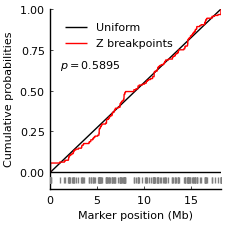

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [42]:
x = 0:1E3:x_pos[end]

cdf = [sum(breakpoints_1recomb .<= i)/length(breakpoints_1recomb) for i in x]

fig = plot(size=(225,225))

plot!(fig,[x[1],x[end]]./1E6,[0,1],
    label="Uniform",
    linewidth=1,
    linecolor=:black,
    linealpha=1,
    grid=:off,
    legend_background_color=false,
    legend=:topleft,
    xlims=(0,+Inf),
    ylims=(-0.1,1),
)
plot!(fig,x./1E6,cdf,
    label="Z breakpoints",
    linecolor=:red,
    linewidth=1,
    xlabel="Marker position (Mb)",
    # markersize=1,
    # marker=:vline,
    ylabel="Cumulative probabilities",
    xguidefontsize=8,
    yguidefontsize=8,
)
annotate!(fig,[(1,0.65,Plots.text(L"p=0.5895",8,:left))])

hline!(fig,[0],label="",color=:black)

scatter!(fig,breakpoints_1recomb./1E6,[-0.05],
    label="",
    color=:gray,
    markersize=5,
    marker=:vline)

In [44]:
ExactOneSampleKSTest(vcat(breakpoints_1recomb),
    Uniform(0,1*x_pos[end]))

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests /n/home00/txiong/.julia/packages/HypothesisTests/ED0fC/src/kolmogorov_smirnov.jl:68


Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0573114

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.5895

Details:
    number of observations:   176


In [45]:
dir_output = "$(dir_source_data)/Fig1/Fig1F"

fig_name = "Z_breakpoints_CDF"

savefig(fig,string(dir_output,"/$(fig_name).pdf"))
savefig(fig,string(dir_output,"/$(fig_name).png"))

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


#### Plot phased haplotypes (phase = grandparental phase, not species ancestry)

In [46]:
for chr1 in 30:30

family = "F01-F16"

if family == "F12-F16"
    f_idx = Array(12:16)
elseif family == "F01-F11"
    f_idx = Array(1:11)
else
    f_idx = Array(1:16)
end

marker_skips=2

interference = "0.001"
subdir = "impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference)"

marker_idx_1 = []
male_cM_1 = []
hap1 = []

open("$(dir_source_data)/FigS5toS7/$(subdir)/impute.with_pseudoGrandparents.fixedDiff_only.grandparentPhase.1.recombination1.0.001.interference1.$(interference).$(family).chr.$(chr1).txt","r") do io
    i=1
    for l in eachline(io)
        if string(l[1]) != "#"
            x = split(l,"\t")
            push!(marker_idx_1,x[1])
            push!(male_cM_1,x[2])
            push!(hap1,get_individual_alleles(x[f_idx .+ 4]))
            i = i+1
        end
    end
end

marker_idx_1 = parse.(Int32,marker_idx_1)
male_cM_1 = parse.(Float32,male_cM_1)
hap1 = hcat(hap1...)
    
hap1 = Float16.(hap1)

GC.gc()

idx = 1:marker_skips:size(hap1)[2]
h1 = hap1[:,idx]
m_cM_1 = male_cM_1[idx]

N=size(h1)[1]

marker_pos_1 = get_marker_pos(chr1,dir_source)

x_pos = marker_pos_1[marker_idx_1[idx]];

## remove below if necessary

firstswitch=[]
secondswitch=[]

for i in 1:N
    h = h1[i,:] 
    δ = h[2:end] .- h[1:end-1]
    t = findall(δ .!= 0)
    if length(t) == 0 
        append!(firstswitch,NaN)
        append!(secondswitch,NaN)
    elseif length(t) == 1
        append!(firstswitch,t[1])
        append!(secondswitch,NaN)
    elseif length(t) == 2
        append!(firstswitch,t[1])
        append!(secondswitch,t[2])
    end
end

perm_order = sortperm(firstswitch);

recomb_p = []
recomb_q = []
recomb_double = []
for i in 1:size(h1)[2]
    append!(recomb_p,1 - sum(h1[:,1] .=== h1[:,i])/N)
    append!(recomb_q,1 - sum(h1[:,end] .=== h1[:,i])/N)
    append!(recomb_double,sum((h1[:,1] .!= h1[:,i]) .& (h1[:,end] .!= h1[:,i]))/N)
end
interference = recomb_p .* recomb_q - recomb_double;

fig = plot(size=(800,400),layout=(1,2))
for i in Array(1:size(perm_order)[1])
    plot!(fig,x_pos ./10^6,h1[perm_order[i],:]./2 .+ i,label="",
        seriestype=:steppre,
        linecolor=:white,
        fillcolor=:black,
        xticks=0:1:(x_pos[end]/10^6),
        xlabel="Chr$(chr1), Mb",
        xguidefontsize=8,
        format=:png,
        grid=:off,
        fillrange=i,
        subplot=1)
end
plot!(fig,x_pos ./10^6,recomb_p,
    ylims=(0,1),label="p",
    legend=:topleft,
    color=:blue,
    yticks=0:0.1:1,
    xlabel="Chr$(chr1), Mb",
    xguidefontsize=8,
    xticks=0:1:(x_pos[end]/10^6),
    subplot=2)
plot!(fig,x_pos ./10^6,recomb_q,
    ylims=(0,1),label="q",
    legend=:topleft,
    color=:orange,
    yticks=0:0.1:1,
    xticks=0:1:(x_pos[end]/10^6),
    subplot=2)

plot!(fig,x_pos ./10^6,m_cM_1./100,
    ylims=(0,1),label="cM/100",
    color=:red,
    subplot=2)

# save the figure as one loops over different chromosomes. They can be too large to display here

dir_output = "DIR_OUT"

savefig(fig,string(dir_output,"/chr$(chr1).png"))
    

end

## 3. Z chromosome sequence properties

In [23]:
using StatsPlots

In [25]:
Dxy_data = JLD.load("$(dir_source_data)/FigS16/Dxy.w50kbs50kb.grandparents.jld")
Dxy_dict = Dxy_data["Dxy_dict"];


In [27]:
dxy_auto = vcat([Dxy_dict["HiC_scaffold_$(i)"] for i in 1:29]...)
dxy_auto = dxy_auto[.!isnan.(dxy_auto)];

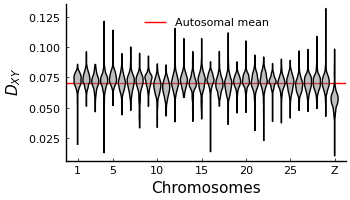

In [28]:
fig = plot(size=(350,200))

hline!(fig,[mean(dxy_auto)],linecolor=:red,label="Autosomal mean",
    legend_position=:top,
    legend_background_color=false)

for i in 1:30
    
    chr = i==30 ? "Z" : "HiC_scaffold_$(i)"
    
    dxy = Dxy_dict[chr][.!isnan.(Dxy_dict[chr])]
    
    violin!(fig,[i],dxy,
        grid=:off,
        xlabel="Chromosomes",
        color=:gray,
        fillalpha=0.5,
        xtickfontsize=8,
        xticks=([1,5,10,15,20,25,30],["1","5","10","15","20","25","Z"]),
        ytickfontsize=8,
        ylabel=L"D_{XY}",
        label="")

end

fig

In [29]:
dir_output = "$(dir_source_data)/FigS16"

fig_name = "Dxy.w50kbs50kb.grandparents"

savefig(fig,string(dir_output,"/$(fig_name).pdf"))
savefig(fig,string(dir_output,"/$(fig_name).png"))